In [10]:
import numpy as np
import pyvista as pv
import vtk
import tensorflow as tf
from FiberNetModels_3D import SyntheticDataGenerator3D, MultiAnisoEikonalPINN_3D 
from matplotlib import cm
#pv.set_jupyter_backend("panel") #If you want interactive 3D plots
pv.set_jupyter_backend("static")

In [2]:
#@title Inputs
# These data files are 3D meshes with data
geometry_file = "./data/LA_model.vtk" # .vtk
maps_number = 1 #@param {type:"slider", min:1, max:5, step:1}
sample_points = 1020 #@param {type:"slider", min:1, max:1500, step:1}
noise_ms = 0.0 #@param {type:"slider", min:0.0, max:5.0, step:0.1}
print("Selected values -> file: %s, maps: %s, sample points: %s, noise (ms): %s" 
        %(geometry_file,maps_number,sample_points,noise_ms))

Selected values -> file: ./data/LA_model.vtk, maps: 1, sample points: 1020, noise (ms): 0.0


In [3]:
np.random.seed(0)
tf.random.set_seed(0)
layers = [3] + [20] * 7 + [1]
CVlayers = [3] + [20] * 7 + [3]

vtk_f = pv.UnstructuredGrid(geometry_file)
points = vtk_f.points
triangs = vtk_f.cells_dict[vtk.VTK_TRIANGLE]
l = vtk_f.cell_data["fibers"]

smooth_basis_file = geometry_file[:-4] + '_smooth_basis.vtk'

synthetic_values = SyntheticDataGenerator3D(geometry_file, maps=maps_number, ppm=sample_points//maps_number, noise=noise_ms)
real_times, sample_times, sample_coords, measurement_mask, fiber_vecs_3D, indices = synthetic_values.get_values()

model = MultiAnisoEikonalPINN_3D(points, triangs, maps_number, sample_coords, 
                                 sample_times, indices, layers, CVlayers, 
                                 smooth_basis_file=smooth_basis_file,
                                 CVmax=3.0, lambda_df=1.e0, lambda_pde=1.e-4, 
                                 lambda_tve=1.e-5, lambda_tva=1.e-9, 
                                 jobs=4)

# Model training
loss_curve = model.train_Adam_minibatch(int(1e3), size=32)
predicted_times, cv, dcv, D_2D, D_3D, evals, evecs, eik_mismatch = model.predict(points)

centroids = (points[triangs[:,0],:] + points[triangs[:,1],:] + points[triangs[:,2],:])/3.
D_cen_3D = model.predict(centroids)[4] # Model values at centroids
predicted_vals_3D, predicted_vecs_3D = np.linalg.eigh(D_cen_3D)

D_mismatch_rad = np.arccos(np.clip(np.abs(np.sum(fiber_vecs_3D[..., :, 2]*predicted_vecs_3D[..., :, 2],1)),0.,1.))
fiber_orientation_error = np.rad2deg(np.mean(D_mismatch_rad))
D_mismatch_degree = np.rad2deg(D_mismatch_rad)
D_mismatch_degree_dist = np.rad2deg(np.percentile(D_mismatch_rad, [25,50,75]))

data_fidelity_error = np.sqrt(np.mean((predicted_times-real_times)**2))
mesh = pv.UnstructuredGrid({vtk.VTK_TRIANGLE: triangs}, points)
mesh.point_data["act_times"] = predicted_times
mesh.point_data["eik_mismatch"] = eik_mismatch
mesh.cell_data["fiber_err"] = D_mismatch_degree
mesh.cell_data["fibers"] = predicted_vecs_3D[..., :, 2]
#mesh.save("output.vtk") #Results can be saved to the disk and viewed in other software like Paraview

2022-06-10 17:34:40.956170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-10 17:34:42.184995: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

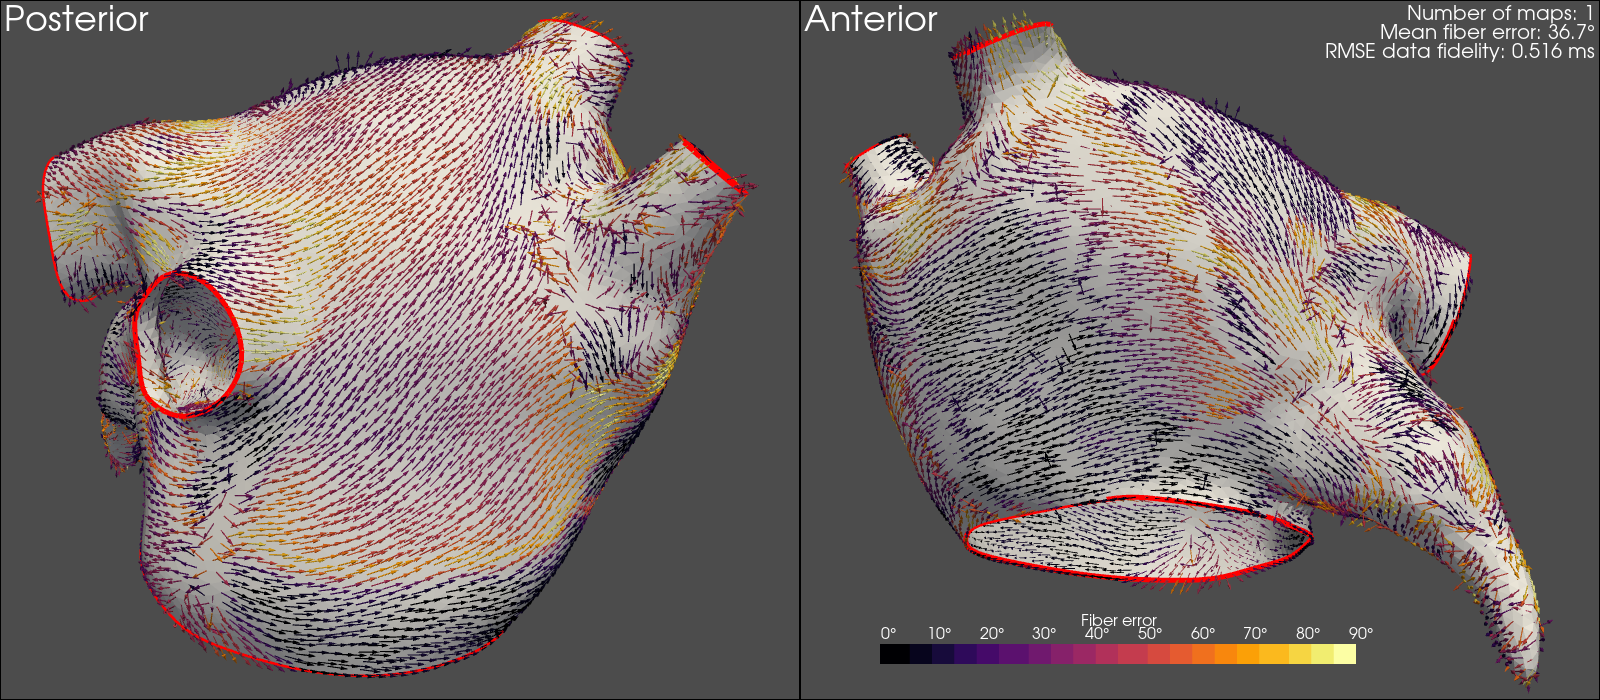

In [12]:
cmap = cm.get_cmap("inferno", 20)
bedges = mesh.extract_feature_edges(feature_edges=False,boundary_edges=True,manifold_edges=False)
plotter = pv.Plotter(window_size=(1600, 700), shape=(1, 2))
plotter.subplot(0, 0)
plotter.add_mesh(mesh, show_scalar_bar=False, color="w")
glyphs = mesh.cell_data_to_point_data().glyph(orient="fibers", scale=False, factor=2)
glyphs.set_active_scalars("fiber_err")
plotter.add_mesh(glyphs, cmap=cmap, show_scalar_bar=False, clim=[0,90])
plotter.add_mesh(bedges, color="red", line_width=5)
plotter.camera.position = [34.90010739823705, -120.06186620991983, -69.20885085393053]
plotter.camera.focal_point = [4.318968801436604, -9.099057508859794, 11.316830437617247]
plotter.camera.up = [-0.23149304827623654, 0.5287886763913683, -0.8165742491164174]
plotter.camera.parallel_scale = 53.2299
plotter.add_text("Posterior",font_size=14)
#plotter.add_camera_orientation_widget()

plotter.subplot(0, 1)
plotter.camera.position = [-65.16720771058229, 103.97243886022419, 65.96968260082595]
plotter.camera.focal_point = [8.569376850316937, -1.10271544535806, 8.921769885950457]
plotter.camera.up = [-0.31968827697870306, 0.26893578053171824, -0.9085554201655415]
plotter.camera.parallel_scale = 53.2299
plotter.add_mesh(mesh, show_scalar_bar=True, color="w")
plotter.add_mesh(bedges, color="red", line_width=5)
plotter.add_mesh(glyphs, cmap=cmap, show_scalar_bar=False, clim=[0,90])
plotter.add_text("Anterior",font_size=14)
plotter.add_scalar_bar('Fiber error', vertical=False,
                    title_font_size=16,
                    label_font_size=16,
                    position_x=0.1,
                    n_labels=10,
                    fmt='%5.0f°')

plotter.add_text(f"Number of maps: {maps_number}\n"\
    f"Mean fiber error: {fiber_orientation_error:.3g}°\n"\
    f"RMSE data fidelity: {data_fidelity_error:.3g} ms",font_size=10,position='upper_right')

plotter.show()